# Time Series Analysis

### Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
#.api imports the public access version of statsmodels
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Use API
quandl.ApiConfig.api_key = 'X8m2y3vXPLPQMjB_2cZu'

In [4]:
#Importing the Federal Reserve Economic Data's "Gross Domestic Product" variable

data = quandl.get('FRED/GDP')

In [18]:
#check data
data.head()

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [6]:
#check shape
data.shape

(300, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

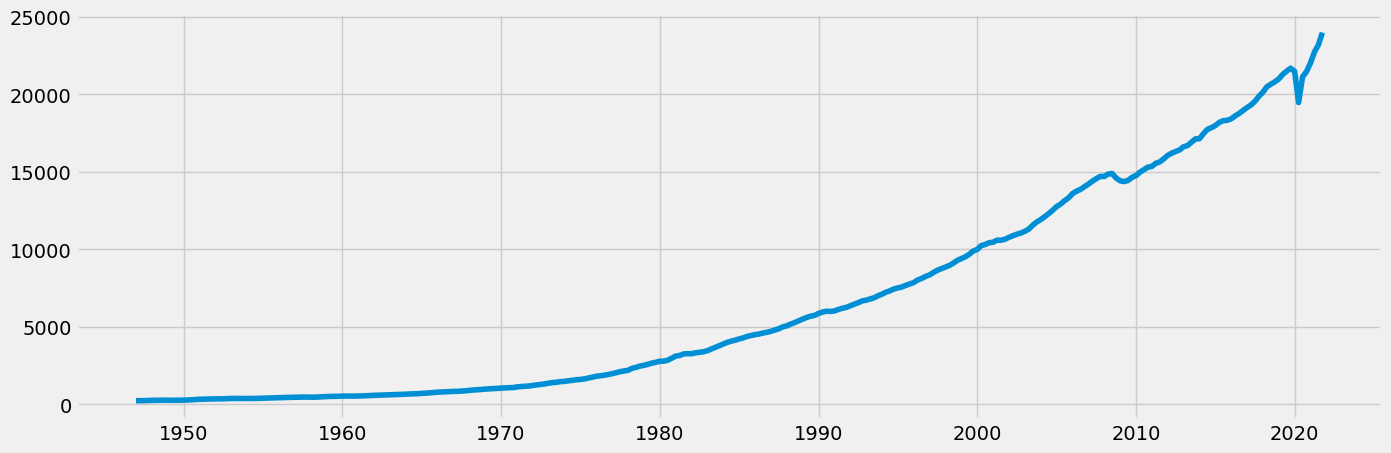

In [9]:
#Using matplotlib to plot the data

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

### Subsetting, wrangling, and cleaning 

In [12]:
#Resetting index so "Date" column is used as filter

data2 = data.reset_index()

In [13]:
data2.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [19]:
GDP_sub = data2.loc[(data2['Date'] >= '1947-01-01') & (data2['Date'] < '2021-10-01')]

In [20]:
GDP_sub.shape

(299, 2)

In [22]:
GDP_sub.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [23]:
# Set the "Date" column as the index

from datetime import datetime

GDP_sub['datetime'] = pd.to_datetime(GDP_sub['Date']) 
GDP_sub = GDP_sub.set_index('datetime') 
GDP_sub.drop(['Date'], axis=1, inplace=True) 
GDP_sub.head()

,Value
datetime,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


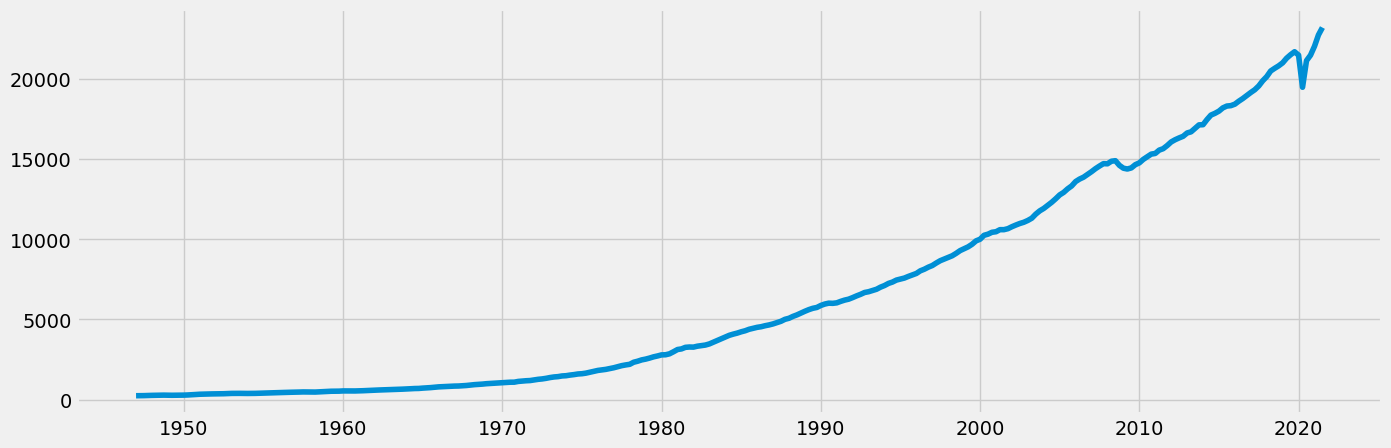

In [24]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(GDP_sub)

In [25]:
#Cleaning (look for nulls and duplicates)
GDP_sub.isnull().sum()

Value    0
dtype: int64

In [26]:
dups = GDP_sub.duplicated()
dups.sum()

0

### Time Series Analysis: Decomposition

In [27]:
#Decomposing using additive model

decomposition = sm.tsa.seasonal_decompose(GDP_sub, model='additive')

In [28]:
from pylab import rcParams # Defining a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

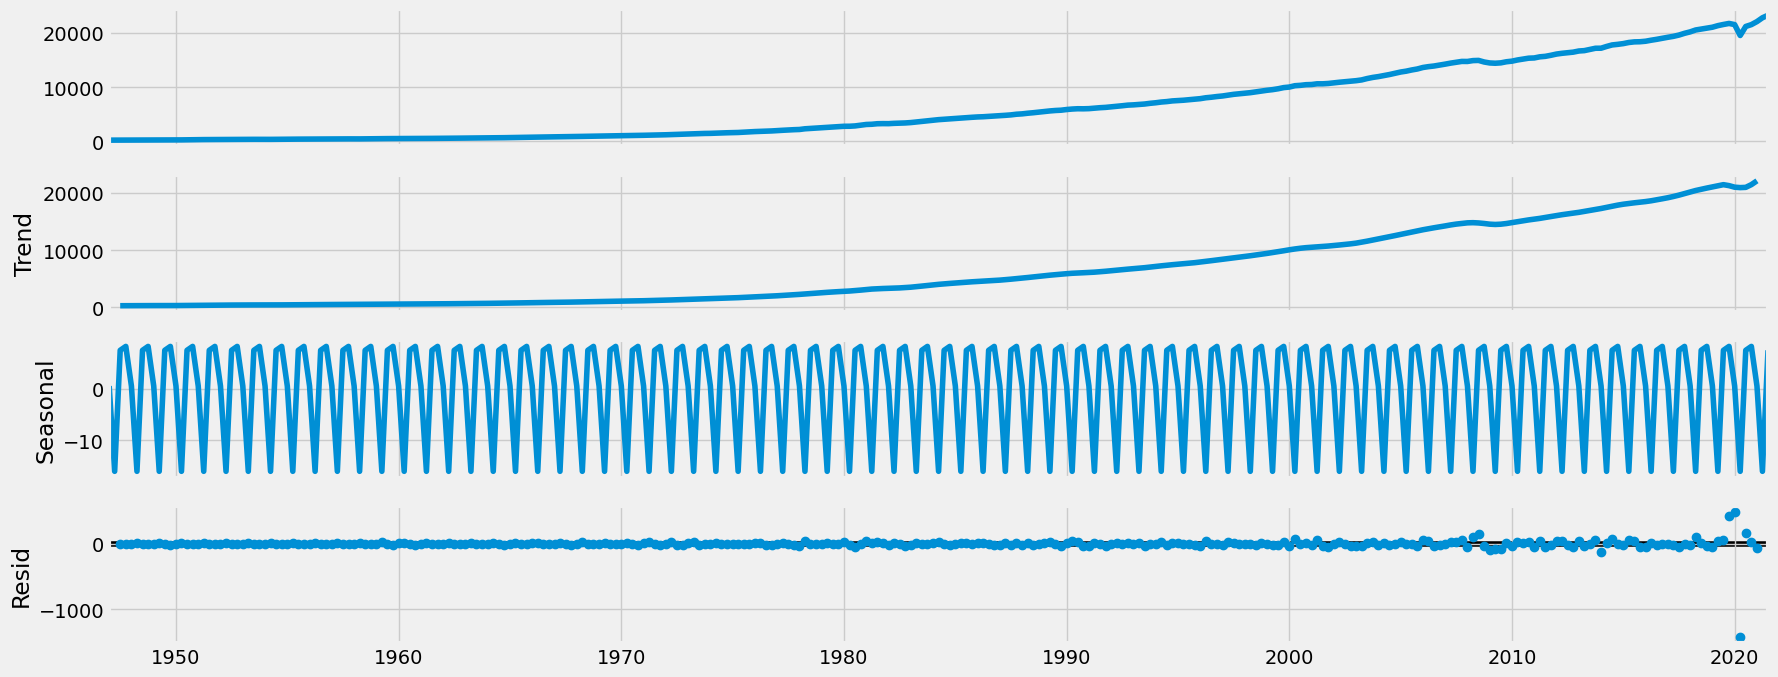

In [29]:
#Plotting separate components

decomposition.plot()
plt.show()

Observation:
- Looking at the trend, there is a consistent upward trend from 1950 to 2020.
- There's also seasonality.
- There was a dip around 2020 for GDP and that could be due to Covid-19 Pandemic

### Conducting Dickey-Fuller Test (Checking for Stationarity)

In [31]:
# 1. Use adfuller() function to return array of numbers
# 2. Define a function that print the correct output

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
   
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(GDP_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   5.528513
p-value                          1.000000
Number of Lags Used              8.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64


Test Statistic is larger than the critical value = null is not rejected.
- This means that the data is non-stationary

### Testing for Autocorrelations

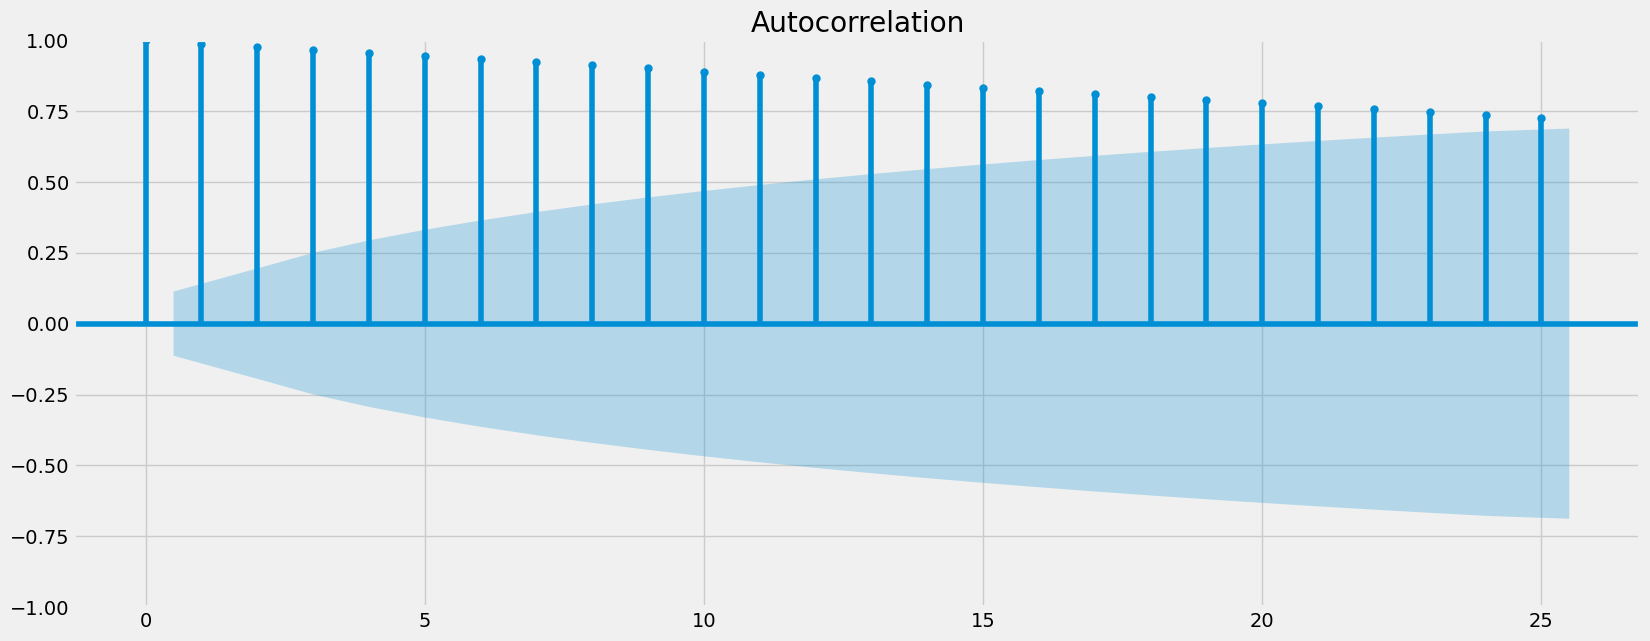

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(GDP_sub)
plt.show()

Since the lags (the vertical lines) go above the the blue edge on the confidence interval (the light blue shaded area), this mean sthat the lags are significantly correlated with each other. Have such results confirms that the data in non-stationary.

### Stationarizing GDP

In [33]:
GDP_diff = GDP_sub - GDP_sub.shift(1) # turns the observation to t-1, making the whole thing t - (t -1)

In [34]:
GDP_diff.dropna(inplace = True) 
# remove missing values
# Having nulls will not let Dickey-Fuller test to run

In [38]:
GDP_diff.head()

,Value
datetime,
1947-04-01,2.804
1947-07-01,3.617
1947-10-01,10.160
1948-01-01,5.997
1948-04-01,6.825


In [39]:
GDP_diff.columns

Index(['Value'], dtype='object')

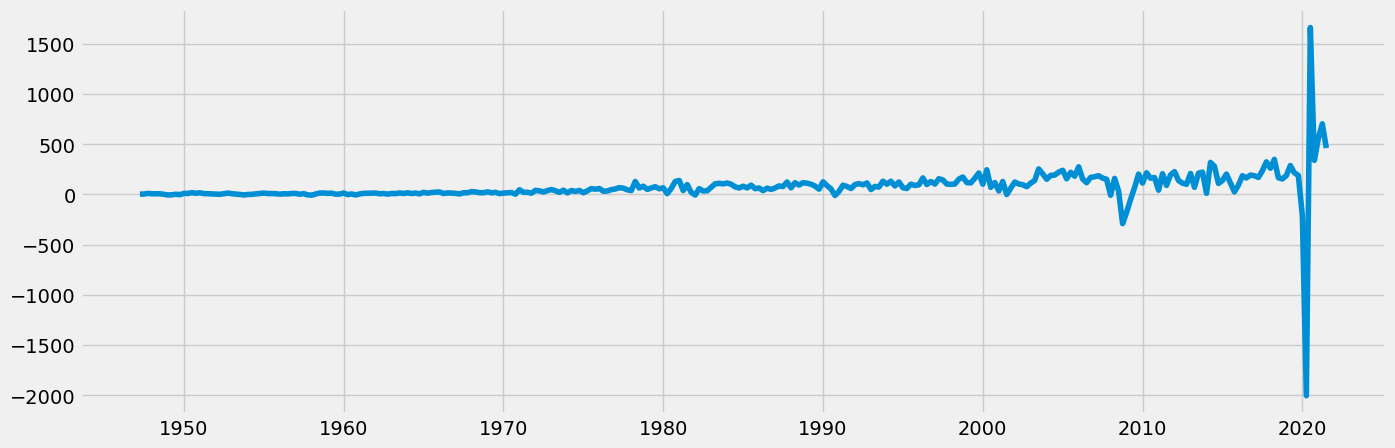

In [40]:
#Checking how differencing affects the time-series

plt.figure(figsize=(15,5), dpi=100)
plt.plot(GDP_diff)

In [41]:
#Run Dickey Fuller Test
dickey_fuller(GDP_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.144746
p-value                          0.696902
Number of Lags Used             16.000000
Number of Observations Used    281.000000
Critical Value (1%)             -3.453838
Critical Value (5%)             -2.871881
Critical Value (10%)            -2.572280
dtype: float64


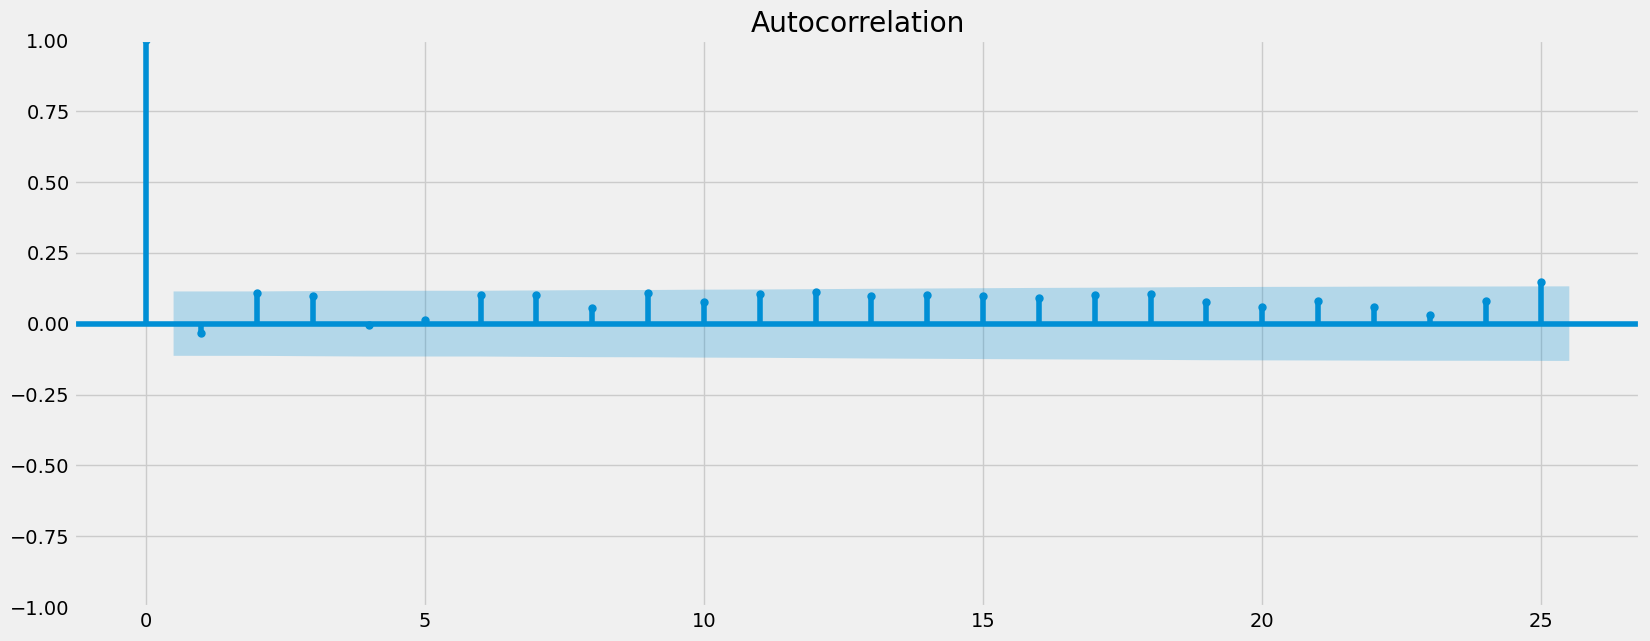

In [43]:
#Run autocorrelation
plot_acf(GDP_diff)
plt.show()

The data is still non-stationary. Will run another differencing

In [44]:
GDP_diff2 = GDP_diff - GDP_diff.shift(1)

In [45]:
GDP_diff2.isnull().sum()

Value    1
dtype: int64

In [46]:
#drop the null
GDP_diff2.dropna(inplace = True)

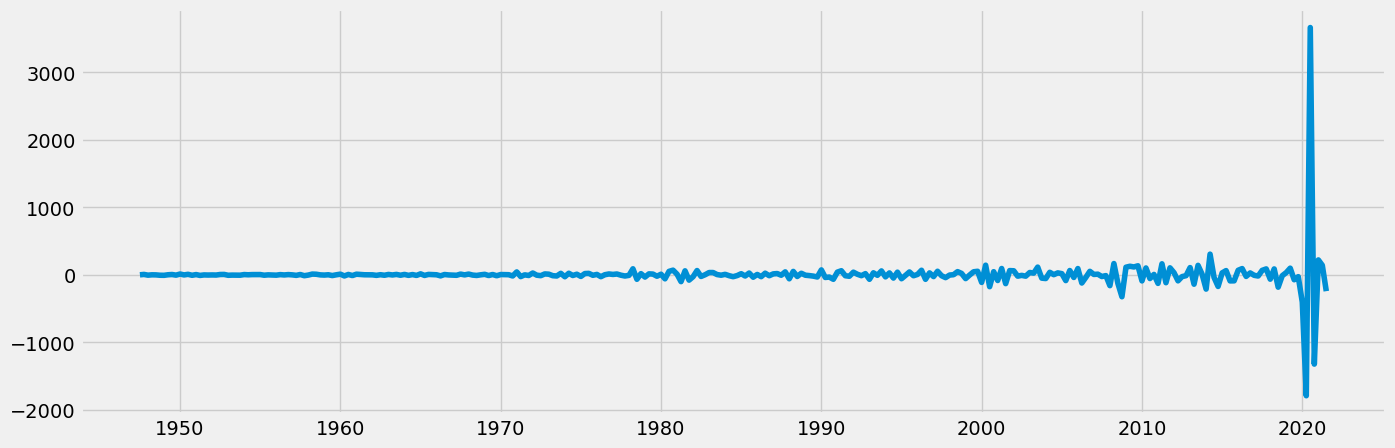

In [47]:
#Check for differencing
plt.figure(figsize=(15,5), dpi=100)
plt.plot(GDP_diff2)

In [48]:
#Run Dickey Fuller Test
dickey_fuller(GDP_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -7.973834e+00
p-value                        2.735838e-12
Number of Lags Used            1.600000e+01
Number of Observations Used    2.800000e+02
Critical Value (1%)           -3.453922e+00
Critical Value (5%)           -2.871918e+00
Critical Value (10%)          -2.572300e+00
dtype: float64


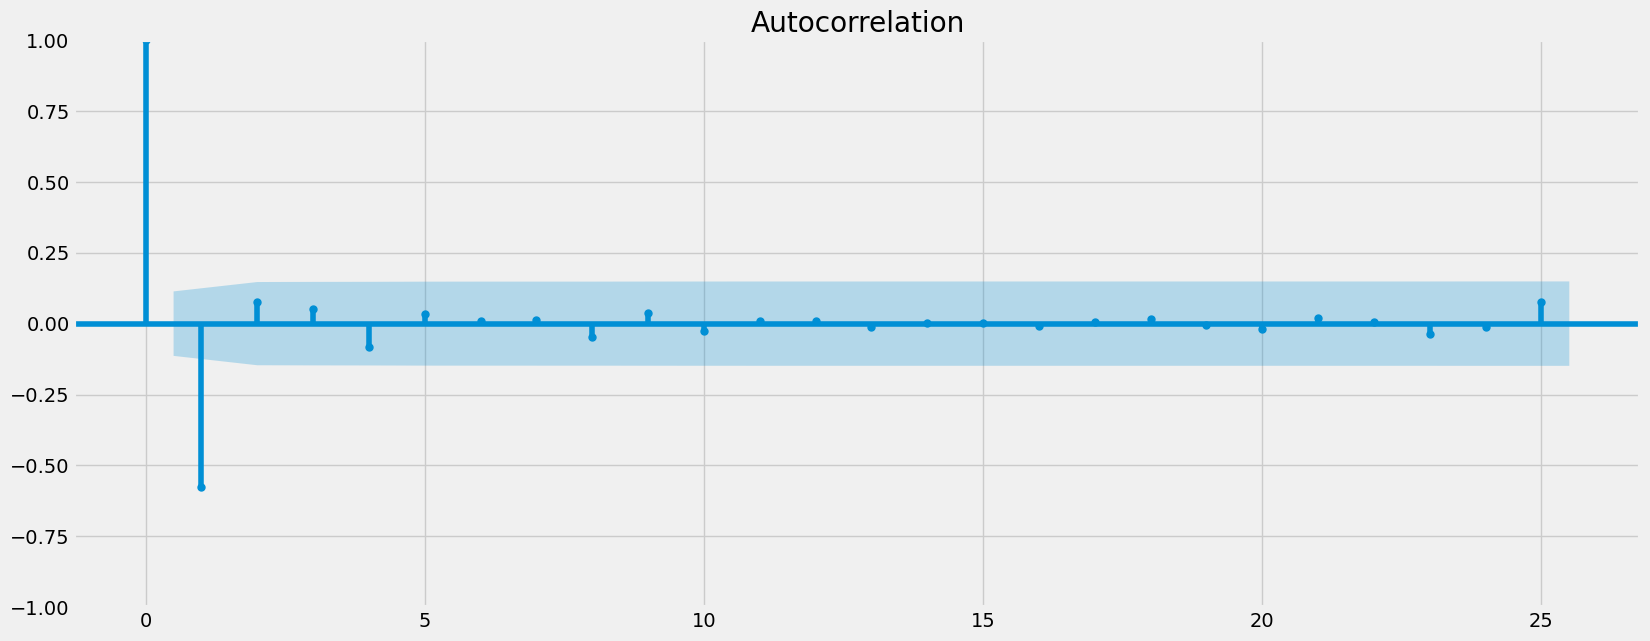

In [49]:
#Run autocorrelation
plot_acf(GDP_diff2)
plt.show()

Now that Test Statistic is smaller than the Critical Value however since the p-value is > 0.05, which means that the null is NOT rejected. Around 2020 was the pandemic which greatly affected the nation's GDP. I suggest to remove the anomaly and run the test in the future.